# Post processing the Offshore ABL case

In [1]:
%%capture 

# Important libraries header information
# ----------------------------------

# change this directory as necessary
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import matplotlib.pyplot as plt
import amrwind_frontend  as amrwind
import numpy             as np
from matplotlib import cm
import re
import time

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
def plotrotorlines(zhh, rotorD, xstart, xend, **kwargs):
    plt.hlines(zhh,             xstart, xend, linewidth=1.0, **kwargs) # Plot the HH line
    plt.hlines(zhh+rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line
    plt.hlines(zhh-rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line    

## Postprocess and compare AMR-Wind velocity profiles

In [3]:
 # Set your run directory here
#casedir = '/nscratch/lcheung/2021/SWIFT_Neutral_WS8.7_Alpha0.14/AMRWind_Precursor/precursor1'

caselist = [ 
            {'rundir':'/lustre/orion/cfd162/scratch/lcheung/testruns/testneutral', 'tag':'testneutral',
             'inputfile':'AMRWind_precursor1.inp',
             'ncfile':'post_processing/abl_statistics00000.nc', 'avgtimes':[15000, 20000],
             'mstyle':{'mfc':'b', 'marker':'s', 'lw':0, 'mec':'k',}, 'lstyle':{'color':'b'}},    
           ]

# Average between 15,000 sec to 20,000 sec
avgtimes = [15000, 20000]

# Hub-height locations
plotheights=[26.5, 90, 153.5]

# Load the entire netcdf in memory
loadinmemory = False   # Do this only if there's enough RAM and for new (python 3+ netCDF4) libraries

In [4]:
for case in caselist:
    case['App'] = amrwind.MyApp.init_nogui()
    tstart = time.time()
    case['App'].ABLpostpro_loadnetcdffile(case['rundir']+'/'+case['ncfile'], usemmap=loadinmemory)
    tend   = time.time()
    print("Load time: %f sec"%(tend-tstart))

Loading /lustre/orion/cfd162/scratch/lcheung/testruns/testneutral/post_processing/abl_statistics00000.nc
Time range: 0.500000 to 20000.000000
Done.
Load time: 16.714506 sec


In [5]:
# First, let's look at the averaged statistics
for case in caselist:
    tstart = time.time()
    case['reportstats'] = case['App'].ABLpostpro_printreport(avgt=case['avgtimes'], avgz=plotheights)
    tend   = time.time()
    print("Compute time: %f sec"%(tend-tstart))

Loading u'u'_r
Loading v
Loading w'w'_r
Loading u
Loading v'v'_r
Loading w'theta'_r
Loading theta
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha     ObukhovL 
      ===         ====         ====         ====         ====         ====         ==== 
    26.50 6.103191e+00 2.679115e+02 8.957860e-02 1.511464e-01 1.203593e-01 -1.126097e+06 
    90.00 6.930958e+00 2.700025e+02 6.321540e-02 9.741534e-02 7.010447e-02 3.154035e+06 
   153.50 7.210897e+00 2.719480e+02 5.740232e-02 8.632017e-02 7.809965e-02 1.822314e+06 

ustar: 0.287006
Compute time: 6.893518 sec


In [6]:
# Let's compute the shear based on z=10m and z=169m
z_lr = 26.5
z_ur = 153.5
print("%10s %10s %10s %10s"%("CASE", "LR-HH", "LR-UR", "HH-UR"))
for case in caselist:
    ULR  = case['reportstats']['Uhoriz'][0]
    UHH  = case['reportstats']['Uhoriz'][1]
    UUR  = case['reportstats']['Uhoriz'][2]
    case['alpha_LR_HH']  = alpha_LR_HH  = np.log(ULR/UHH)/np.log(z_lr/90.0)
    case['alpha_LR_UR']  = alpha_LR_UR  = np.log(ULR/UUR)/np.log(z_lr/z_ur)
    case['alpha_HH_UR']  = alpha_HH_UR  = np.log(UHH/UUR)/np.log(90.0/z_ur)
    #print("%s alpha_10_169 = %f"%(case['tag'], alpha_60_91))
    print("%10s % 10f % 10f % 10f"%(case['tag'], alpha_LR_HH, alpha_LR_UR, alpha_HH_UR))

      CASE      LR-HH      LR-UR      HH-UR
testneutral   0.104024   0.094948   0.074164


## Target values
From Ken's analysis
```
WS: 6.931 m/s	TI: 8.7%
Shear: 0.16 	Veer: 0.0345°/m
```

In [7]:
# These values came from Mithu's post-processed ARM data - Stable
ARM_alpha = 0.16
ARM_TI    = 0.087
ARM_WS    = 6.937
ARM_zHH   = 90.0
rotorD    = 127.0

## Parameters used in the cases

In [14]:
# Make a table of the relevant parameters
QOIs = ['ABL.surface_roughness_z0', 'ABL.surface_temp_rate']
for case in caselist:
    case['App'].loadAMRWindInput(case['rundir']+'/'+case['inputfile'])
    for q in QOIs:
        case[q] = case['App'].getAMRWindInput(q)

print()
print('%20s'%'CASE', end='')
for q in QOIs: print('%30s '%q,end='')
print()
print('%20s'%'----', end='')
for q in QOIs: print('%30s '%'-----',end='')
print()
for case in caselist:
    print('%20s'%case['tag'], end='')
    for q in QOIs: 
        print('%30.4f '%case[q],end='')
    print()

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()

                CASE      ABL.surface_roughness_z0          ABL.surface_temp_rate 
                ----                         -----                          ----- 
         testneutral                        0.0100                         0.0000 


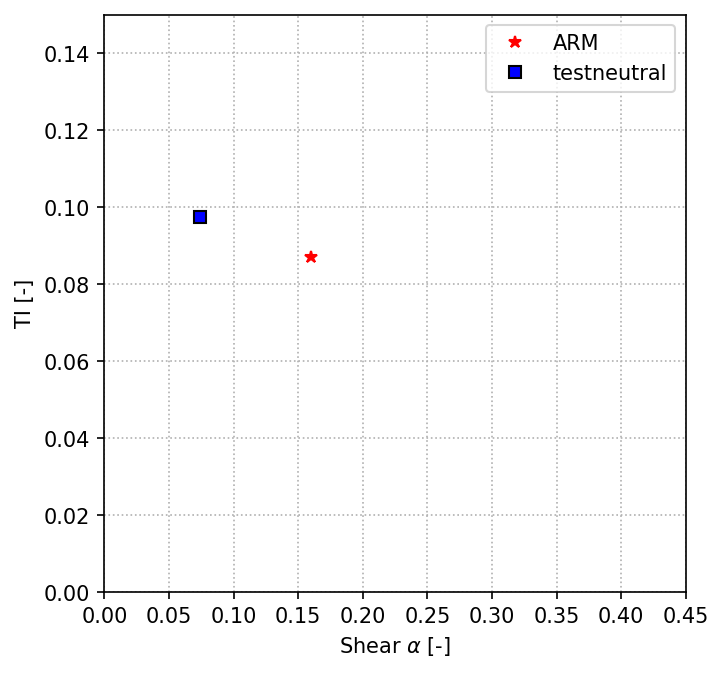

In [9]:
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)

# Plot the ARM data
plt.plot(ARM_alpha, ARM_TI, 'r*', label='ARM')

# Plot the AMR-Wind results
for case in caselist:
    mstyle=case['mstyle']
    #plt.plot(case['reportstats']['Alpha'][3], case['reportstats']['TI_horiz'][2], label=case['tag'], **mstyle)
    #plt.plot(case['alpha_30_169'], case['reportstats']['TI_horiz'][2], label=case['tag'], **mstyle)
    #plt.plot(case['alpha_60_91'], case['reportstats']['TI_horiz'][2], label=case['tag'], **mstyle)
    plt.plot(case['alpha_HH_UR'], case['reportstats']['TI_horiz'][1], label=case['tag'], **mstyle)

#plt.xlim([0.25, 0.45])
plt.xlim([0.0, 0.45])
plt.ylim([0, 0.15])
plt.xlabel(r'Shear $\alpha$ [-]')
plt.ylabel('TI [-]')
plt.grid(ls=':')
plt.legend()

## Plot velocity profile

Loading u
Loading v


Text(0.5, 1.0, 'Horizontal wind speed')

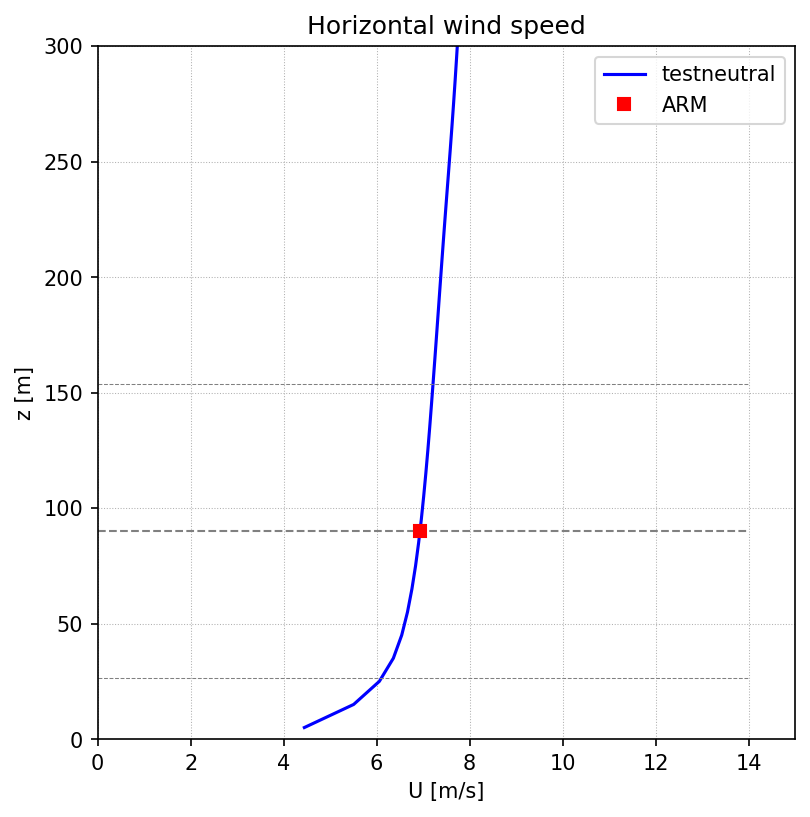

In [10]:
# Plot velocity
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)


# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['Uhoriz'], avgt=case['avgtimes'])
    lstyle=case['lstyle']
    plt.plot(amrdat['Uhoriz']['data'], amrdat['Uhoriz']['z'], label=case['tag'], **lstyle)

# Plot the turbine dimensions
plotrotorlines(ARM_zHH, rotorD, 0, 14, linestyles='dashed', color='gray',)

ax.plot(ARM_WS, ARM_zHH, 's', color='r', label='ARM')
ax.legend()
ax.set_xlim([0, 15])
ax.set_xlabel('U [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylim([0,300])
ax.set_ylabel('z [m]')
ax.set_title('Horizontal wind speed')

# Compare AMR-Wind temperature profiles

Loading theta


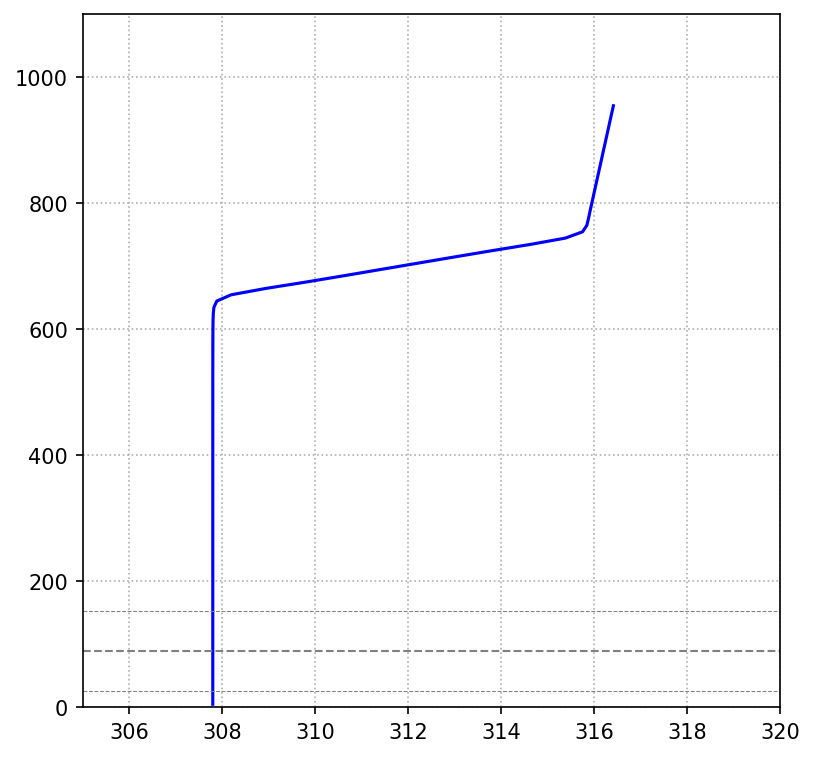

In [11]:
# Plot temperature
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['Temperature'], avgt=case['avgtimes'])
    lstyle=case['lstyle']
    plt.plot(amrdat['T']['data'], amrdat['T']['z'], label=case['tag'], **lstyle)

# Plot the turbine dimensions
plotrotorlines(ARM_zHH, rotorD, 305, 320, linestyles='dashed', color='gray',)

plt.ylim([0, 1100])
plt.xlim([305, 320])
plt.grid(ls=':')

# Compare AMR-Wind veer profiles

Loading u
Loading v


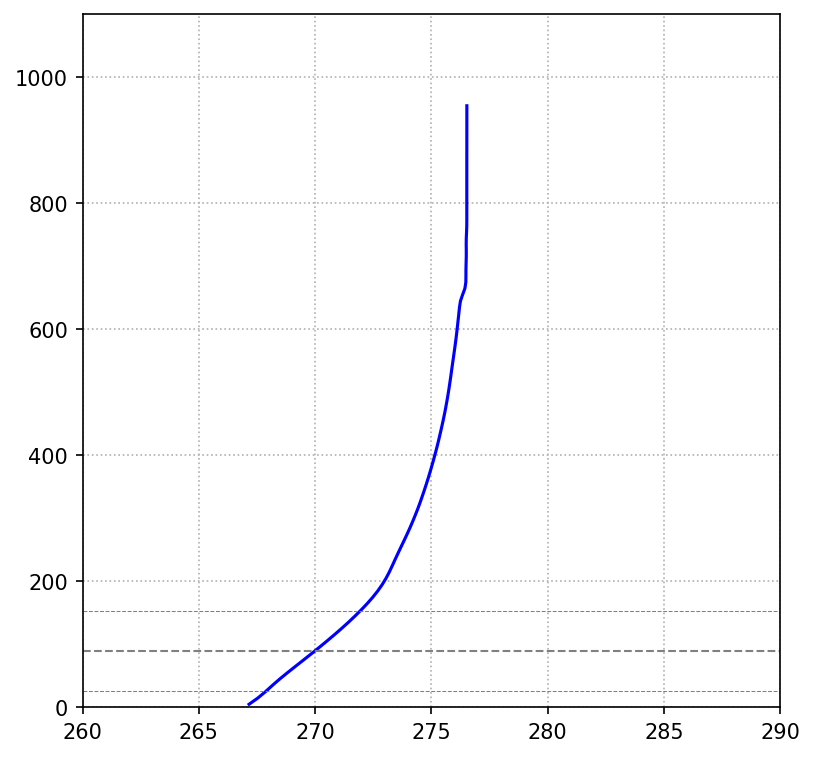

In [12]:
# Plot veer
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['WindDir'], avgt=case['avgtimes'])
    lstyle=case['lstyle']
    plt.plot(amrdat['WindDir']['data'], amrdat['WindDir']['z'], label=case['tag'], **lstyle)

# Plot the turbine dimensions
plotrotorlines(ARM_zHH, rotorD, 260, 290, linestyles='dashed', color='gray',)
plt.ylim([0, 1100]) #[0, 2000]
plt.xlim([260, 290]) #[170, 190]
plt.grid(ls=':')

Loading u
Loading v
Loading u'u'_r
Loading v'v'_r


Text(0.5, 1.0, 'Horizontal TI')

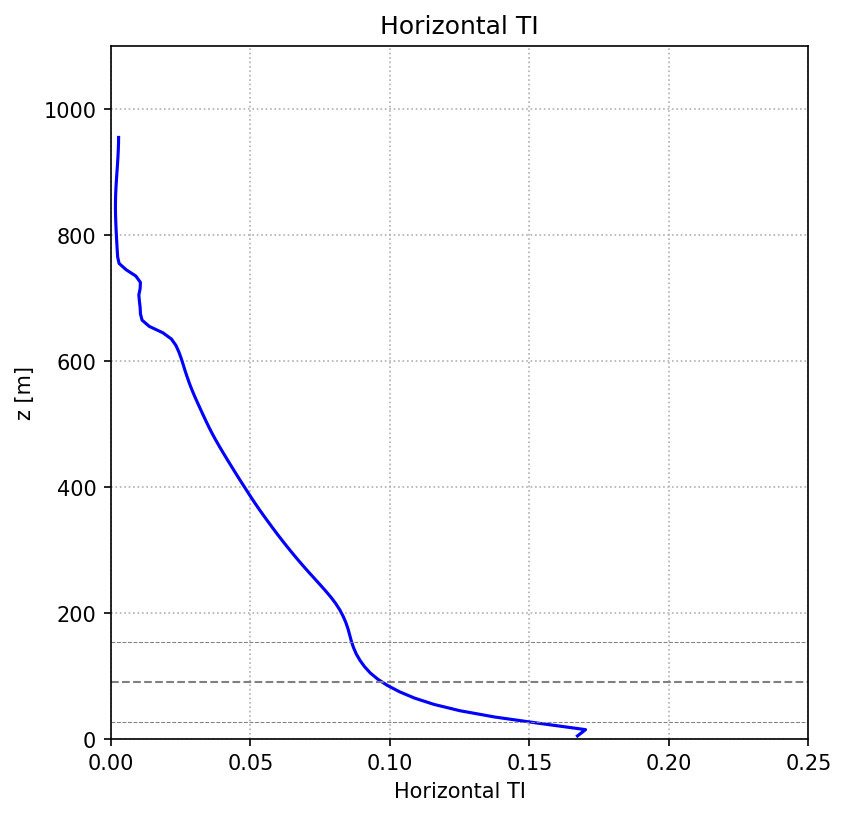

In [13]:
# Plot TI
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)

# This command returns the data, and then you can plot it individually
for case in caselist:
    amrdat = case['App'].ABLpostpro_plotprofiles(plotvars=['TI_horiz'], avgt=case['avgtimes'])
    lstyle=case['lstyle']
    plt.plot(amrdat['TI_horiz']['data'], amrdat['TI_horiz']['z'], label=case['tag'], **lstyle)

# Plot the turbine dimensions
plotrotorlines(ARM_zHH, rotorD, 0, 1, linestyles='dashed', color='gray',)

plt.ylim([0, 1100])
plt.xlim([0, .25])
plt.grid(ls=':')
ax.set_ylabel('z [m]')
ax.set_xlabel('Horizontal TI')
ax.set_title('Horizontal TI')